In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

x = pd.read_csv('/content/drive/MyDrive/TataSteel10years.csv')
# x = pd.read_csv('TISC Historical Data.csv')

Mounted at /content/drive


In [ ]:
x.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,06/19/2024,180.00,182.26,182.48,179.35,27460000.0,-0.62
1,06/18/2024,181.12,183.80,184.60,180.60,35030000.0,-1.11
2,06/14/2024,183.15,182.95,183.50,181.40,28510000.0,0.32
3,06/13/2024,182.56,183.40,184.10,180.51,36670000.0,0.18
4,06/12/2024,182.23,182.25,183.87,181.50,33310000.0,0.50


In [ ]:
x['Vol.'] = x['Vol.'].str.replace('M', '').astype(float) * 1e6
x['Change %'] = x['Change %'].str.replace('%', '').astype(float)

In [ ]:
reversed_x = x.iloc[::-1]
reversed_x.head()
x_sorted = reversed_x.reset_index(drop=True)
x_sorted['Date'] = pd.to_datetime(x_sorted['Date'])
split = int(len(x_sorted)*0.7)
test = x_sorted[split:]
train = x_sorted[:split]

In [ ]:
test = test.reset_index(drop=True)
train = train.reset_index(drop=True)

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

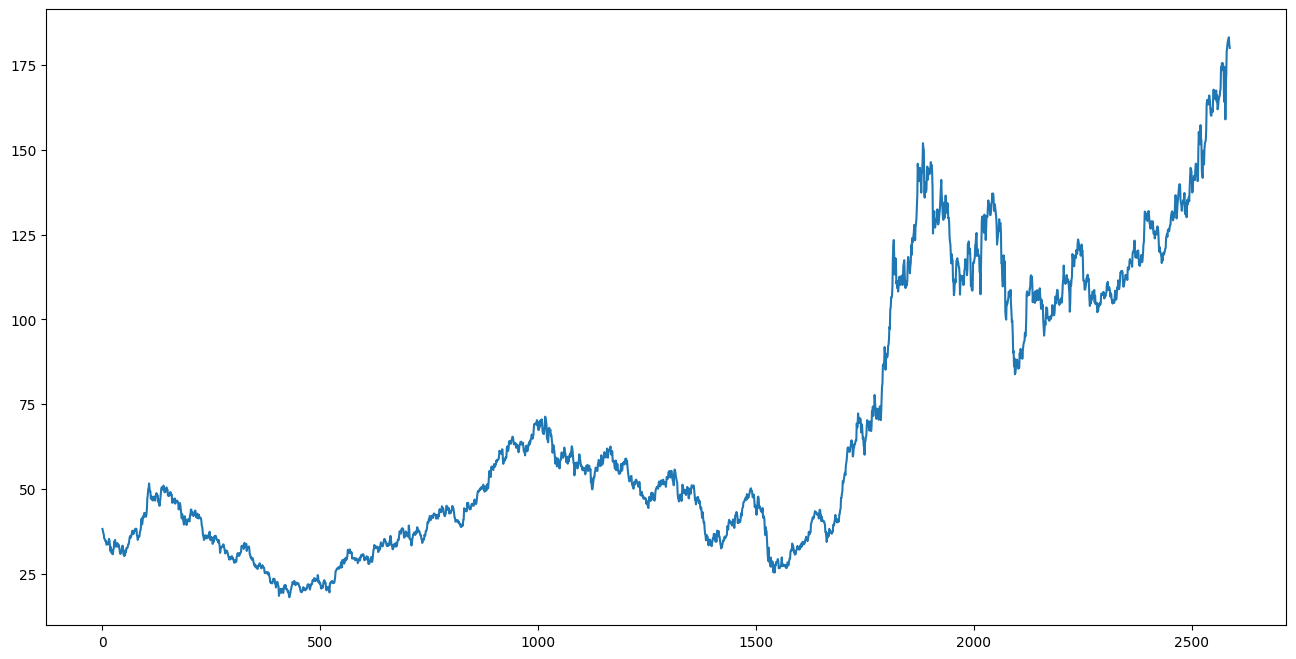

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(x_sorted["Price"], label="Day-wise price")

x.isnull().sum()

In [ ]:
# LSTM
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set = train.iloc[:, 1:2].values
training_set_scaled = sc.fit_transform(training_set)

X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

regressor = Sequential()

regressor.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 128, return_sequences = True))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units = 128, return_sequences = True))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units = 128, return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 128))
regressor.add( Dropout(0.5))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_error'])
regressor.fit(X_train, y_train, epochs = 10, batch_size = 32, verbose=1)

actual_stock_price = test.iloc[:,1:2].values

dataset_total = pd.concat((train['Price'], test['Price']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

Epoch 1/10
55/55 [==============================] - 39s 533ms/step - loss: 0.0177 - mean_absolute_error: 0.0953
Epoch 2/10
55/55 [==============================] - 29s 532ms/step - loss: 0.0036 - mean_absolute_error: 0.0442
Epoch 3/10
55/55 [==============================] - 30s 545ms/step - loss: 0.0033 - mean_absolute_error: 0.0423
Epoch 4/10
55/55 [==============================] - 30s 552ms/step - loss: 0.0031 - mean_absolute_error: 0.0405
Epoch 5/10
55/55 [==============================] - 29s 537ms/step - loss: 0.0029 - mean_absolute_error: 0.0401
Epoch 6/10
55/55 [==============================] - 29s 532ms/step - loss: 0.0027 - mean_absolute_error: 0.0392
Epoch 7/10
55/55 [==============================] - 31s 558ms/step - loss: 0.0025 - mean_absolute_error: 0.0375
Epoch 8/10
55/55 [==============================] - 29s 537ms/step - loss: 0.0029 - mean_absolute_error: 0.0402
Epoch 9/10
55/55 [==============================] - 32s 591ms/step - loss: 0.0028 - mean_absolute_error:

In [ ]:
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_price_lstm = regressor.predict(X_test)
predicted_price_lstm = sc.inverse_transform(predicted_price_lstm)

25/25 [==============================] - 6s 143ms/step


In [ ]:
# MLP Model
X_train_mlp = train[['Open', 'High', 'Low', 'Change %']]
y_train_mlp = train['Price']

X_test_mlp = test[['Open', 'High', 'Low', 'Change %']]

from sklearn.neural_network import MLPRegressor, MLPClassifier

mlp = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=1)
mlp.fit(X_train_mlp, y_train_mlp)

predicted_price_mlp = mlp.predict(X_test_mlp)

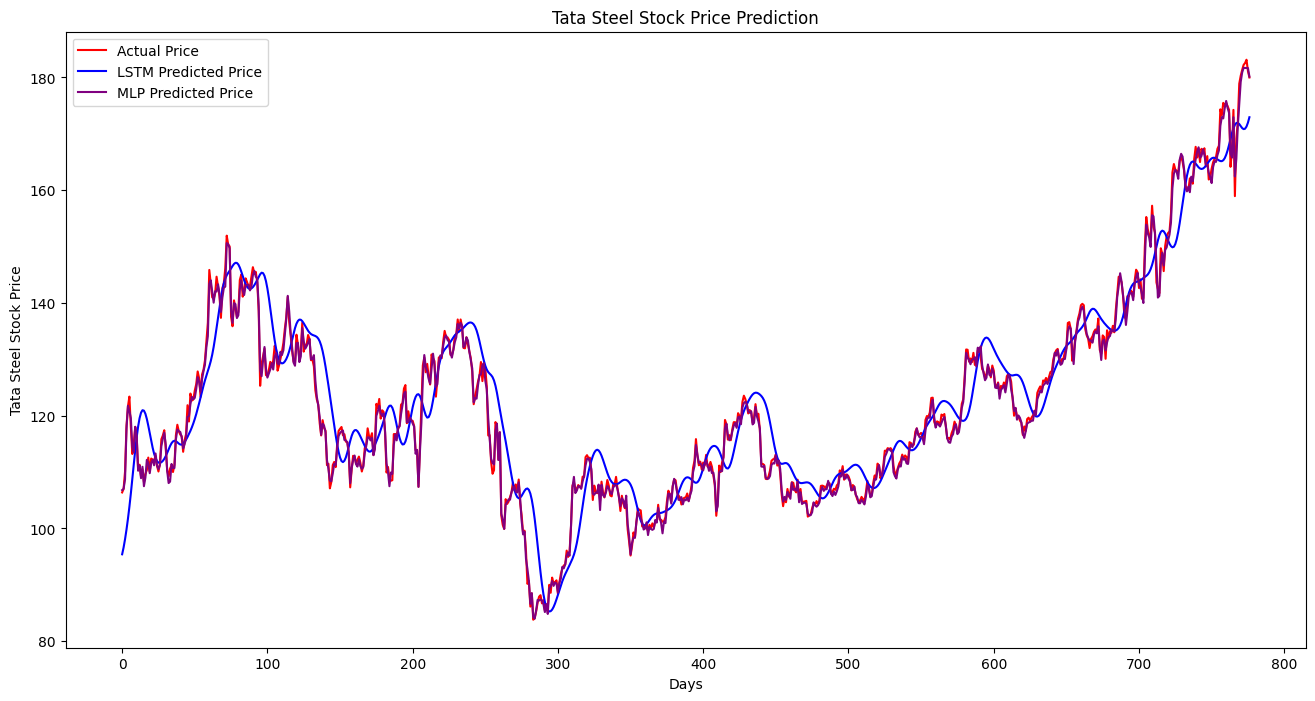

In [ ]:
# Plotting results
plt.figure(figsize=(16,8))
plt.plot(actual_stock_price, color = 'red', label = 'Actual Price')
plt.plot(predicted_price_lstm, color = 'blue', label = 'LSTM Predicted Price')
plt.plot(predicted_price_mlp, color = 'purple', label = 'MLP Predicted Price')
plt.title('Tata Steel Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Tata Steel Stock Price')
plt.legend()
plt.show()

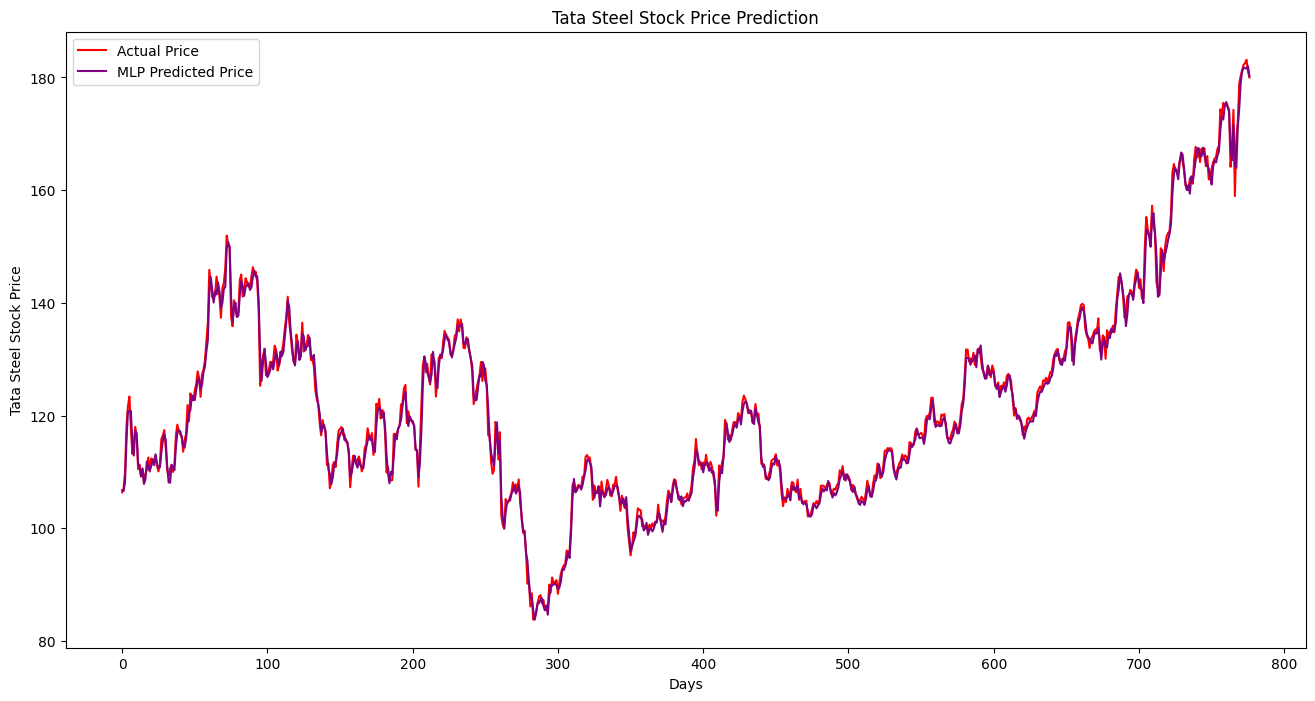

In [ ]:
# Plotting results only MLP
plt.figure(figsize=(16,8))
plt.plot(actual_stock_price, color = 'red', label = 'Actual Price')
plt.plot(predicted_price_mlp, color = 'purple', label = 'MLP Predicted Price')
plt.title('Tata Steel Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Tata Steel Stock Price')
plt.legend()
plt.show()

In [ ]:
# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error

def print_metrics(model_name, actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(actual, predicted)
    mda = median_absolute_error(actual, predicted)
    directional_accuracy = np.mean(np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - actual[:-1])) * 100

    print(f"{model_name} Metrics:")
    print("MAE:", mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAPE:", mape)
    print("Median Absolute Error:", mda)
    print("Directional Accuracy:", directional_accuracy, "%")
    print()

print_metrics("LSTM", actual_stock_price, predicted_price_lstm)
print_metrics("MLP", actual_stock_price, predicted_price_mlp)

LSTM Metrics:
MAE: 4.645907679180995
MSE: 37.843545834490115
RMSE: 6.151710805498753
MAPE: 0.0389751847201435
Median Absolute Error: 3.490931701660159
Directional Accuracy: 53.350515463917525 %

MLP Metrics:
MAE: 1.03871144010095
MSE: 1.8588293273415117
RMSE: 1.3633889127250198
MAPE: 0.008484392013757856
Median Absolute Error: 0.8530916090447107
Directional Accuracy: 51.228046285471365 %



1/1 [==============================] - 0s 120ms/step


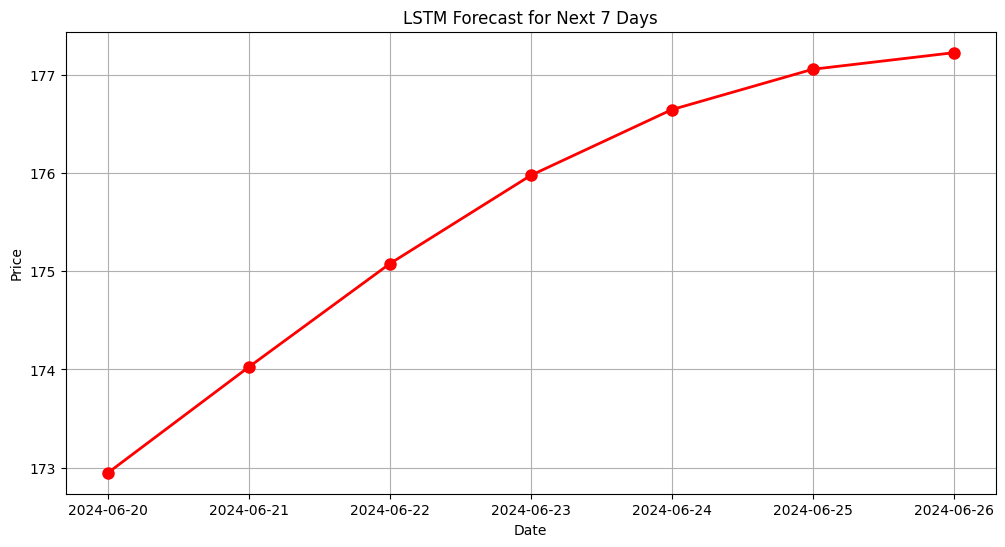

         Date  Forecasted Price
0  2024-06-20        172.948288
1  2024-06-21        174.025848
2  2024-06-22        175.076981
3  2024-06-23        175.975983
4  2024-06-24        176.644958
5  2024-06-25        177.056351
6  2024-06-26        177.225021


In [ ]:
# Forecasting for the next 7 days with LSTM
predicted_price_next_7_days = []
current_input = X_test[-1]

for i in range(7):
    pred = regressor.predict(current_input.reshape(1, 60, 1))
    predicted_price_next_7_days.append(pred[0, 0])
    current_input = np.append(current_input[1:], pred, axis=0)

predicted_price_next_7_days = np.array(predicted_price_next_7_days).reshape(-1, 1)
predicted_price_next_7_days_scaled = sc.inverse_transform(predicted_price_next_7_days)

last_date = pd.to_datetime('2024-06-19')
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7)

plt.figure(figsize=(12, 6))
plt.plot(forecast_index, predicted_price_next_7_days_scaled, color='red', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.title('LSTM Forecast for Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

forecast_df = pd.DataFrame({'Date': forecast_index.date, 'Forecasted Price': predicted_price_next_7_days_scaled.flatten()})
print(forecast_df)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegress

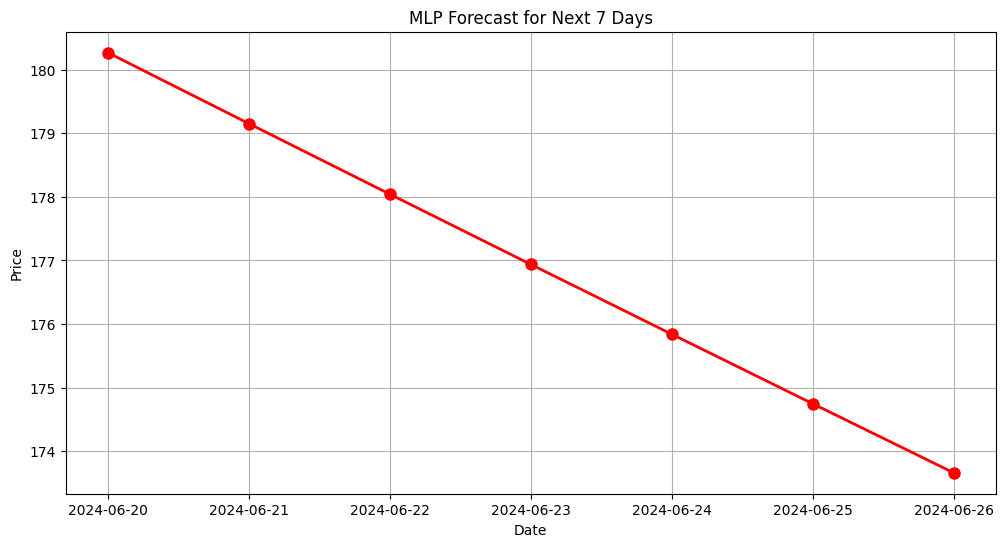

         Date  Forecasted Price
0  2024-06-20        180.264948
1  2024-06-21        179.150420
2  2024-06-22        178.041724
3  2024-06-23        176.938832
4  2024-06-24        175.841711
5  2024-06-25        174.750333
6  2024-06-26        173.664668


In [ ]:
# Forecasting for the next 7 days with MLP
last_known_values = test[['Open', 'High', 'Low']].iloc[-1].values.reshape(1, -1)
predicted_price_next_7_days = []

for i in range(7):
    pred = mlp.predict(last_known_values)
    predicted_price_next_7_days.append(pred[0])

    last_known_values = np.array([pred[0], pred[0], pred[0]]).reshape(1, -1)

predicted_price_next_7_days = np.array(predicted_price_next_7_days).reshape(-1, 1)

last_date = pd.to_datetime(test['Date'].iloc[-1])
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7)

plt.figure(figsize=(12, 6))
plt.plot(forecast_index, predicted_price_next_7_days, color='red', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.title('MLP Forecast for Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

forecast_df_mlp = pd.DataFrame({'Date': forecast_index.date, 'Forecasted Price': predicted_price_next_7_days.flatten()})
print(forecast_df_mlp)
